In [268]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
from loader import load_data
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)

In [269]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

In [270]:
df = load_data(r"D:\misc\code\bayesian_retry\data_hockey")
df = df.loc[df.Resultat != " -:-"]
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,Id,Liga,Region,Phase,TV/Online
0,Mi,09.09.2015,19:45,ZSC Lions,SC Bern,5:3,1:0|2:3|2:0,NaN,Ende,False,"Hallenstadion AG, Zürich",9038,20161105071114,NL A,CH,Regular Season,NaN
1,Fr,11.09.2015,19:45,SC Bern,SCL Tigers,7:1,1:0|4:1|2:0,NaN,Ende,False,"PostFinance-Arena, Bern",17031,20161105071001,NL A,CH,Regular Season,NaN
2,Fr,11.09.2015,19:45,HC Davos,Fribourg-Gottéron,4:5,1:0|1:3|2:1|0:1,SO,Ende,False,"Vaillant Arena, Davos",4488,20161105071002,NL A,CH,Regular Season,NaN
3,Fr,11.09.2015,19:45,Genève-Servette HC,HC Ambri-Piotta,8:2,1:2|4:0|3:0,NaN,Ende,False,"Les Vernets, Genève",5804,20161105071003,NL A,CH,Regular Season,NaN
4,Fr,11.09.2015,19:45,EHC Kloten,EHC Biel-Bienne,3:7,2:1|0:3|1:3,NaN,Ende,False,"SWISS Arena, Kloten",4152,20161105071004,NL A,CH,Regular Season,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,Sa,23.04.2022,20:00,EV Zug,ZSC Lions,1:2,1:0|0:0|0:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000413,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2454,Mo,25.04.2022,20:00,ZSC Lions,EV Zug,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000414,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2455,Mi,27.04.2022,20:00,EV Zug,ZSC Lions,4:1,0:0|1:1|3:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000415,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2456,Fr,29.04.2022,20:00,ZSC Lions,EV Zug,0:2,0:1|0:0|0:1,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000416,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"


# Preprocessing and data exploration

In [271]:
# create a dictionary to store the points for each team
points_dict = {}
hcl_home = []
hcl_away = []

# iterate over each row in the dataframe
for index, row in df.iterrows():
    # extract the team names
    home_team = row['Home']
    away_team = row['Away']
    
    # extract the result for the home and away team
    home_result = row['Resultat'].split(':')[0].strip()
    away_result = row['Resultat'].split(':')[1].strip()
    
    # add points to the home team
    if home_team not in points_dict:
        points_dict[home_team] = {'total': 0, 'home': 0, 'away': 0}
    # add to total points column
    points_dict[home_team]['total'] += int(home_result)
    points_dict[home_team]['home'] += int(home_result)

    # add to list of hcl points
    if home_team == 'HC Lugano':
        hcl_home.append(home_result)
    # add to specific team column
    points_dict[home_team][away_team + ' (away)'] = points_dict[home_team].get(away_team + ' (away)', 0) + int(away_result)
    
    # add points to the away team
    if away_team not in points_dict:
        points_dict[away_team] = {'total': 0, 'home': 0, 'away': 0}
    points_dict[away_team]['total'] += int(away_result)
    points_dict[away_team]['away'] += int(away_result)

    # add to list of hcl points
    if away_team == 'HC Lugano':
        hcl_away.append(away_result)

    points_dict[away_team][home_team + ' (home)'] = points_dict[away_team].get(home_team + ' (home)', 0) + int(home_result)

# create a new dataframe from the points_dict
points_df = pd.DataFrame.from_dict(points_dict, orient='index')

In [272]:
points_df

,total,home,away,SC Bern (away),Lausanne HC (away),HC Ambri-Piotta (home),EHC Biel-Bienne (home),Fribourg-Gottéron (away),SCL Tigers (home),EHC Kloten (away),...,EV Zug (away),HC Davos (home),SC Rapperswil-Jona Lakers (home),SC Rapperswil-Jona Lakers (away),HC Ajoie (away),HC Ajoie (home),ZSC Lions (home),ZSC Lions (away),SC Langenthal (away),SC Langenthal (home)
ZSC Lions,1258,668,590,63.0,26.0,32.0,60.0,37.0,42.0,23.0,...,55.0,46.0,31.0,21.0,4.0,8.0,NaN,NaN,NaN,NaN
SC Bern,1223,656,567,NaN,49.0,36.0,64.0,42.0,42.0,21.0,...,50.0,55.0,22.0,15.0,1.0,3.0,54.0,57.0,NaN,NaN
SCL Tigers,954,488,466,45.0,54.0,55.0,66.0,33.0,NaN,32.0,...,57.0,58.0,29.0,26.0,5.0,5.0,74.0,76.0,NaN,NaN
HC Davos,1212,624,588,52.0,46.0,60.0,54.0,39.0,35.0,19.0,...,67.0,NaN,47.0,42.0,0.0,6.0,57.0,48.0,NaN,NaN
Fribourg-Gottéron,1086,604,482,50.0,50.0,56.0,42.0,NaN,34.0,17.0,...,49.0,50.0,33.0,19.0,4.0,1.0,56.0,44.0,NaN,NaN
Genève-Servette HC,1118,606,512,57.0,48.0,34.0,67.0,46.0,30.0,16.0,...,47.0,26.0,20.0,14.0,5.0,7.0,44.0,37.0,NaN,NaN
HC Ambri-Piotta,992,536,456,43.0,44.0,NaN,68.0,35.0,45.0,27.0,...,59.0,62.0,33.0,30.0,2.0,5.0,51.0,42.0,3.0,1.0
EHC Kloten,471,248,223,16.0,28.0,34.0,18.0,21.0,32.0,NaN,...,24.0,30.0,6.0,11.0,NaN,NaN,23.0,30.0,NaN,NaN
EHC Biel-Bienne,1151,631,520,64.0,42.0,48.0,NaN,51.0,56.0,19.0,...,43.0,66.0,28.0,12.0,1.0,2.0,59.0,62.0,NaN,NaN
HC Lugano,1233,691,542,43.0,40.0,53.0,71.0,42.0,40.0,18.0,...,84.0,59.0,31.0,28.0,2.0,5.0,77.0,45.0,NaN,NaN


In [273]:
# select HC Lugano, HC Ambri-Piotta for our first hypotheses test.
df_1 = points_df[points_df.index.isin(['HC Lugano', 'HC Ambri-Piotta'])]
df_1

,total,home,away,SC Bern (away),Lausanne HC (away),HC Ambri-Piotta (home),EHC Biel-Bienne (home),Fribourg-Gottéron (away),SCL Tigers (home),EHC Kloten (away),...,EV Zug (away),HC Davos (home),SC Rapperswil-Jona Lakers (home),SC Rapperswil-Jona Lakers (away),HC Ajoie (away),HC Ajoie (home),ZSC Lions (home),ZSC Lions (away),SC Langenthal (away),SC Langenthal (home)
HC Ambri-Piotta,992,536,456,43.0,44.0,NaN,68.0,35.0,45.0,27.0,...,59.0,62.0,33.0,30.0,2.0,5.0,51.0,42.0,3.0,1.0
HC Lugano,1233,691,542,43.0,40.0,53.0,71.0,42.0,40.0,18.0,...,84.0,59.0,31.0,28.0,2.0,5.0,77.0,45.0,NaN,NaN


# Hypothesis test 1
We want to compare if HC Lugano scores more goals while playing at home or away.

In [274]:
# cast to float numpy arrays for pymc3
points_home = df_1.iloc[0, 3:].values
points_away = df_1.iloc[1, 3:].values
points_home = np.array(points_home, dtype=float)
points_away = np.array(points_away, dtype=float)

In [284]:
hcl_home, hcl_away = np.array(sorted(hcl_home), dtype=float), np.array(sorted(hcl_away), dtype=float)

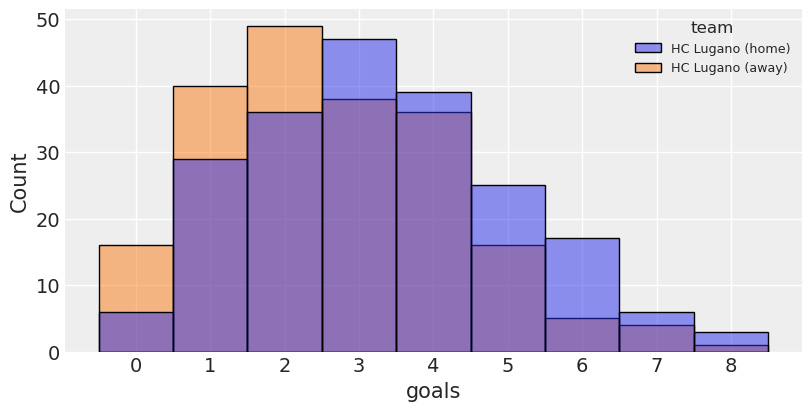

In [283]:
y  = pd.DataFrame(dict(goals=np.r_[hcl_home, hcl_away], team=np.r_[["HC Lugano (home)"]*len(hcl_home), ['HC Lugano (away)']*len(hcl_away)]))
sns.histplot(data=y, x="goals", hue="team", bins=8);

In [285]:
print(f"Sample mean goals at home: {np.mean(hcl_home):.3f}")
print(f"Sample mean goals away: {np.mean(hcl_away):.3f}")

Sample mean goals at home: 3.322
Sample mean goals away: 2.644


# Research question
From the distributions we see that when the game is played at home the mean goals are higher.

We want to test if this is true:
* Are the expected goals for the home team higher than the ones away?

We assume the distribution is Normal.

# Setup

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_{home}$, $\bar{y}_{away}$) 

    * sample standard deviations ($s_{home}, s_{away}$) 

    * numerosity ($n_{home}, n_{away}$)


* The sample are drawn from two populations with unknown parameters $\mu_{home}, \mu_{away}, \sigma_{home}, \sigma_{away}$.

# Background information to set the prior
From a research we found the mean goals per game is 7.2. Given this we can divide the score between the two teams, resulting in a mean of 3.6 goals per team in one game.

Extreme values of goals are 0 and 8. A plausible value of standard deviation in the population is thus   (3.6 - 0)/2 = 1.8.

# Prior for $\mu_{\text{home}}$ and $\mu_{\text{away}}$

* The  mean goals of the population lies in (1.8, 5.4);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{home}}   \sim  N (3.6, 1.8)
$$
$$
\mu_{\text{away}}   \sim  N (3.6, 1.8)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.

